In [2]:
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
class SketchDataset(Dataset):
    def __init__(self, photo_dir, sketch_dir, transform=None):
        self.photo_paths = sorted(glob(os.path.join(photo_dir, "*.*")))
        self.sketch_paths = sorted(glob(os.path.join(sketch_dir, "*.*")))
        self.transform = transform

        # Check for mismatched lengths
        if len(self.photo_paths) != len(self.sketch_paths):
            raise ValueError("Number of photos and sketches do not match!")

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):
        photo_path = self.photo_paths[idx]
        sketch_path = self.sketch_paths[idx]

        # Load images
        photo = Image.open(photo_path).convert("RGB")
        sketch = Image.open(sketch_path).convert("RGB")

        # Apply transforms
        if self.transform:
            photo = self.transform(photo)
            sketch = self.transform(sketch)

        return photo, sketch

In [5]:
# Define data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Paths to the dataset
photo_dir = "/kaggle/input/cuhk-face-sketch-database-cufs/photos"
sketch_dir = "/kaggle/input/cuhk-face-sketch-database-cufs/sketches"

# Create Dataset and DataLoader
dataset = SketchDataset(photo_dir=photo_dir, sketch_dir=sketch_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Loaded dataset with {len(dataset)} samples.")

Loaded dataset with 188 samples.


In [6]:
import torch.nn as nn

# Define a simple generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
generator = Generator().to(device)

In [7]:
# Define optimizer and loss
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
criterion = nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    for i, (photos, sketches) in enumerate(data_loader):
        # Move data to device
        photos = photos.to(device)
        sketches = sketches.to(device)

        # Forward pass
        outputs = generator(photos)
        loss = criterion(outputs, sketches)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")

Epoch [1/100], Step [10/12], Loss: 0.5075
Epoch [2/100], Step [10/12], Loss: 0.2125
Epoch [3/100], Step [10/12], Loss: 0.1863
Epoch [4/100], Step [10/12], Loss: 0.1930
Epoch [5/100], Step [10/12], Loss: 0.1807
Epoch [6/100], Step [10/12], Loss: 0.2164
Epoch [7/100], Step [10/12], Loss: 0.1845
Epoch [8/100], Step [10/12], Loss: 0.1899
Epoch [9/100], Step [10/12], Loss: 0.1820
Epoch [10/100], Step [10/12], Loss: 0.1885
Epoch [11/100], Step [10/12], Loss: 0.1520
Epoch [12/100], Step [10/12], Loss: 0.1343
Epoch [13/100], Step [10/12], Loss: 0.1973
Epoch [14/100], Step [10/12], Loss: 0.1810
Epoch [15/100], Step [10/12], Loss: 0.1981
Epoch [16/100], Step [10/12], Loss: 0.1714
Epoch [17/100], Step [10/12], Loss: 0.1346
Epoch [18/100], Step [10/12], Loss: 0.1693
Epoch [19/100], Step [10/12], Loss: 0.1588
Epoch [20/100], Step [10/12], Loss: 0.1785
Epoch [21/100], Step [10/12], Loss: 0.1479
Epoch [22/100], Step [10/12], Loss: 0.1570
Epoch [23/100], Step [10/12], Loss: 0.1626
Epoch [24/100], Step

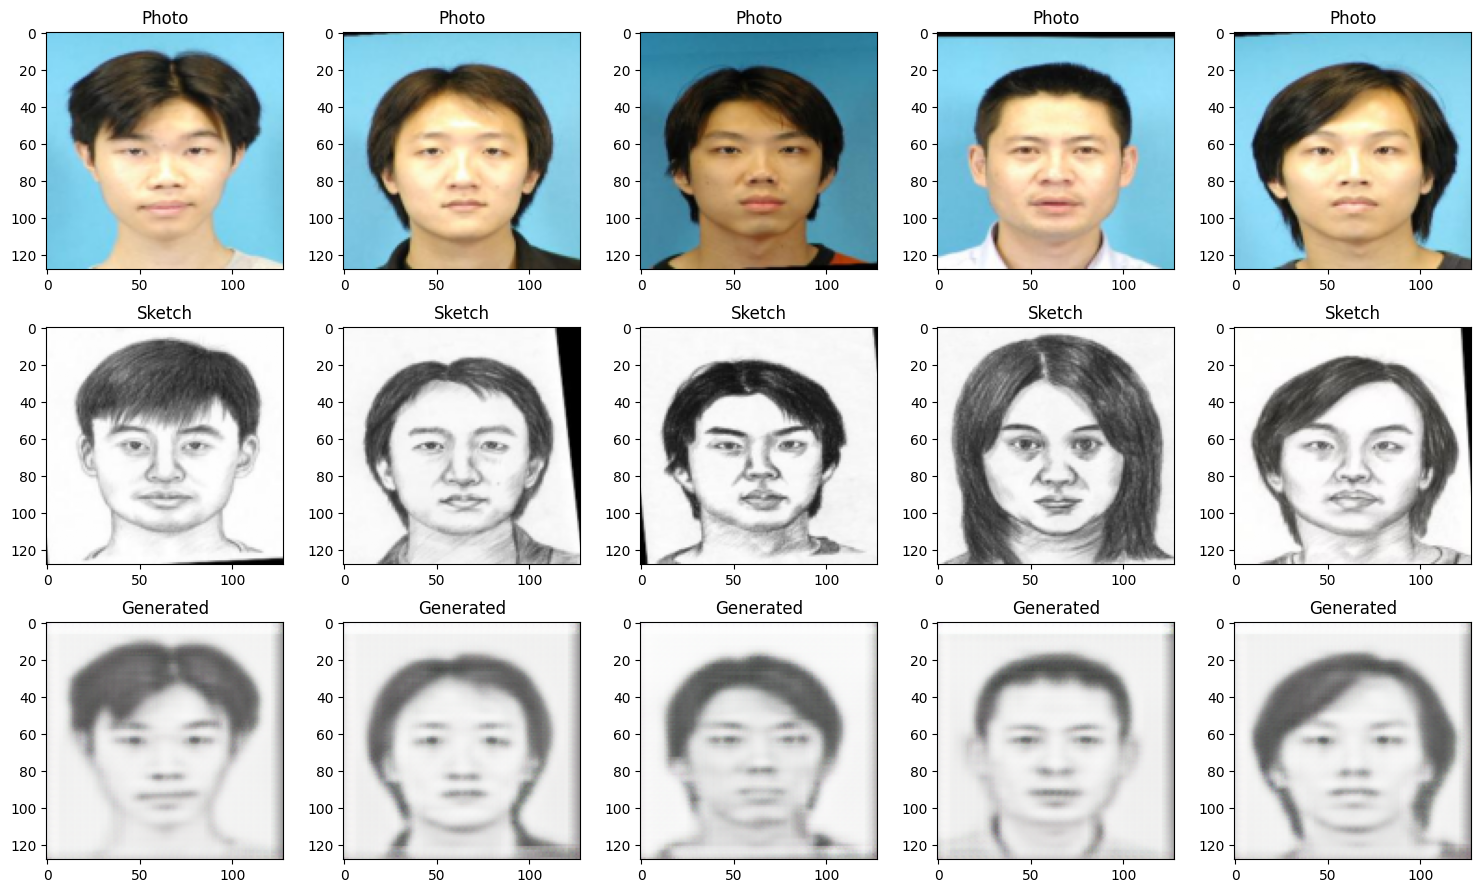

In [8]:
# Visualize a batch of predictions
def visualize_results():
    photos, sketches = next(iter(data_loader))
    photos = photos.to(device)
    sketches = sketches.to(device)

    with torch.no_grad():
        outputs = generator(photos)

    # Move tensors to CPU for visualization
    photos = photos.cpu().numpy()
    sketches = sketches.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # Plot results
    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axs[0, i].imshow(photos[i].transpose(1, 2, 0) * 0.5 + 0.5)  # Denormalize
        axs[0, i].set_title("Photo")
        axs[1, i].imshow(sketches[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axs[1, i].set_title("Sketch")
        axs[2, i].imshow(outputs[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axs[2, i].set_title("Generated")

    plt.tight_layout()
    plt.show()

# Call visualization function
visualize_results()

In [9]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.encoder(x)
        x = x.view(batch_size, -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = z.view(batch_size, -1, 1, 1)
        return self.decoder(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [11]:
from torch.optim import Adam

# Optimizers
gen = Generator(noise_dim=100).to(device)
disc = Discriminator().to(device)
vae = VAE(latent_dim=100).to(device)
optimizer_gen = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_disc = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [16]:
for epoch in range(epochs):
    for real_images, _ in data_loader:  # Adjust `_` if labels are present
        # Move real images to the device
        real_images = real_images.to(device)
        
        # Train Discriminator
        noise = torch.randn(real_images.size(0), 100, 1, 1, device=device)  # Noise on GPU
        fake_images = gen(noise)  # Generate fake images
        
        # Real and fake labels (match shape of discriminator output)
        real_labels = torch.ones_like(disc(real_images))  # Shape: (batch_size, 1, 13, 13)
        fake_labels = torch.zeros_like(disc(fake_images.detach()))  # Shape: (batch_size, 1, 13, 13)
        
        # Discriminator loss
        disc_real_loss = criterion(disc(real_images), real_labels)
        disc_fake_loss = criterion(disc(fake_images.detach()), fake_labels)
        disc_loss = disc_real_loss + disc_fake_loss
        
        optimizer_disc.zero_grad()
        disc_loss.backward()
        optimizer_disc.step()
        
        # Train Generator
        gen_loss = criterion(disc(fake_images), real_labels)  # Use real_labels for generator (fooling discriminator)
        optimizer_gen.zero_grad()
        gen_loss.backward()
        optimizer_gen.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 13, 13])) that is different to the input size (torch.Size([16, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([12, 1, 13, 13])) that is different to the input size (torch.Size([12, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Gen Loss: 0.9982, Disc Loss: 0.0119
Epoch [2/100], Gen Loss: 1.0000, Disc Loss: 0.0052
Epoch [3/100], Gen Loss: 1.0000, Disc Loss: 0.0010
Epoch [4/100], Gen Loss: 1.0000, Disc Loss: 0.0007
Epoch [5/100], Gen Loss: 1.0000, Disc Loss: 0.0004
Epoch [6/100], Gen Loss: 1.0000, Disc Loss: 0.0003
Epoch [7/100], Gen Loss: 1.0000, Disc Loss: 0.0002
Epoch [8/100], Gen Loss: 1.0000, Disc Loss: 0.0002
Epoch [9/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [10/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [11/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [12/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [13/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [14/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [15/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [16/100], Gen Loss: 1.0000, Disc Loss: 0.0001
Epoch [17/100], Gen Loss: 1.0000, Disc Loss: 0.0000
Epoch [18/100], Gen Loss: 0.9999, Disc Loss: 0.0000
Epoch [19/100], Gen Loss: 0.9999, Disc Loss: 0.0000
Epoch [20/100], Gen L